In [1]:
library(Seurat)

Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix


In [2]:
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
eryp.data <- Read10X(
    '../../data/raw/cite-seq/RNA/citeseq180912/outs/filtered_gene_bc_matrices/mm10')

In [5]:
eryp <- CreateSeuratObject(raw.data = eryp.data, min.cells = 3, min.genes = 200, 
    project = "10X_EryP")

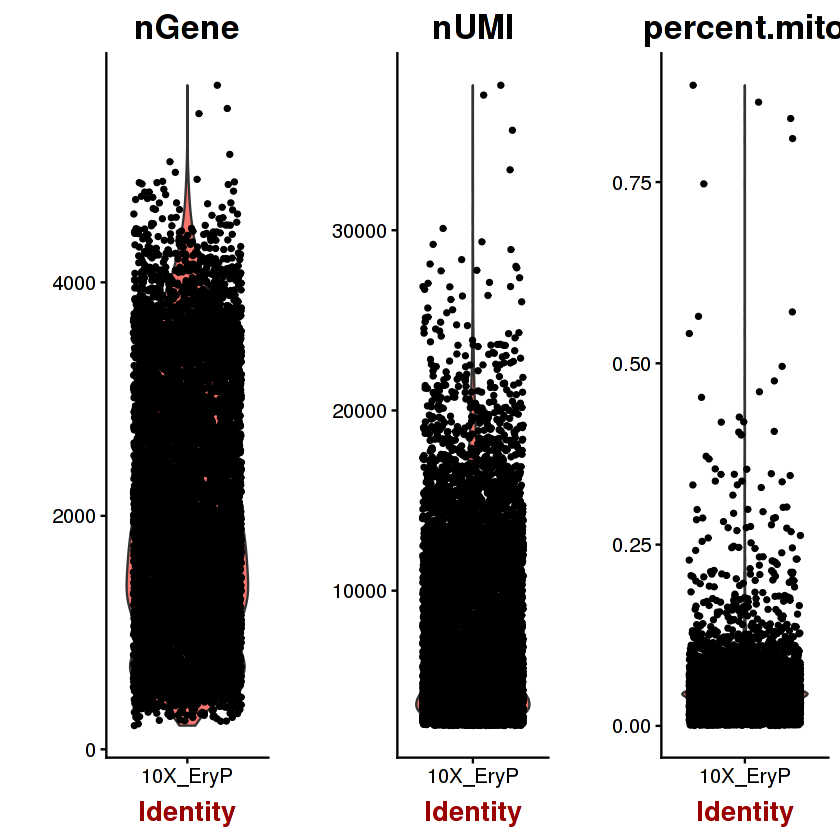

In [6]:
mito.genes <- grep(pattern = "^mt-", x = rownames(x = eryp@data), value = TRUE)
percent.mito <- Matrix::colSums(eryp@raw.data[mito.genes, ])/Matrix::colSums(eryp@raw.data)

eryp <- AddMetaData(object = eryp, metadata = percent.mito, col.name = "percent.mito")
VlnPlot(object = eryp, features.plot = c("nGene", "nUMI", "percent.mito"), nCol = 3)

In [8]:
doublet.scores <- read.table('../../data/intermediate/cite-seq/scrublet_scores.txt',
                             col.names = 'doublet.score', row.names = colnames(eryp.data))

eryp <- AddMetaData(object = eryp, metadata = doublet.scores, col.name = "doublet.score")

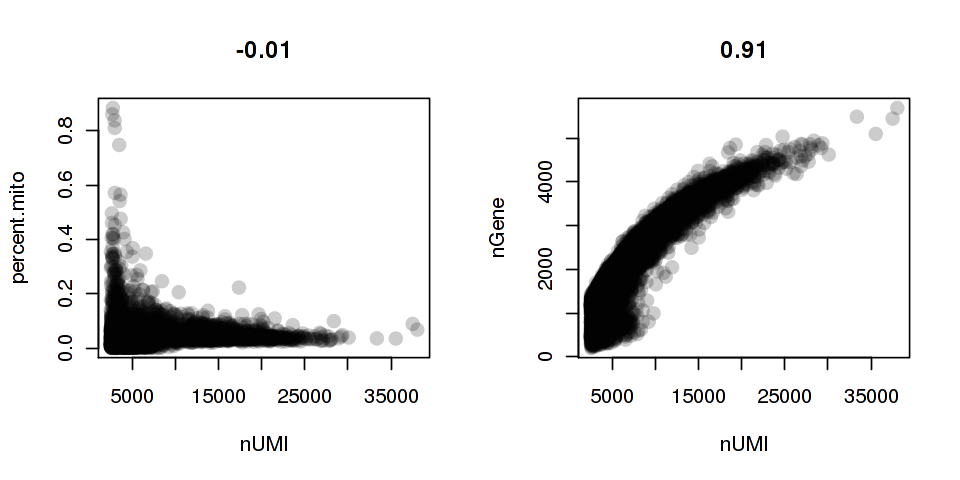

In [9]:
options(repr.plot.width=8, repr.plot.height=4)

par(mfrow = c(1, 2))
GenePlot(object = eryp, gene1 = "nUMI", gene2 = "percent.mito",
         col.use = rgb(red = 0, green = 0, blue = 0, alpha = 0.2))
GenePlot(object = eryp, gene1 = "nUMI", gene2 = "nGene",
         col.use = rgb(red = 0, green = 0, blue = 0, alpha = 0.2))

In [10]:
eryp <- FilterCells(object = eryp, subset.names = c("nGene", "percent.mito"), 
    low.thresholds = c(300, -Inf), high.thresholds = c(5000, 0.09))

In [11]:
scrublet_thresh <- 0.2855555389873682

doublets <- FilterCells(object = eryp, subset.names = c("doublet.score"), 
    high.thresholds = c(scrublet_thresh))

In [12]:
eryp <- NormalizeData(object = eryp, normalization.method = "LogNormalize", 
    scale.factor = 10000)


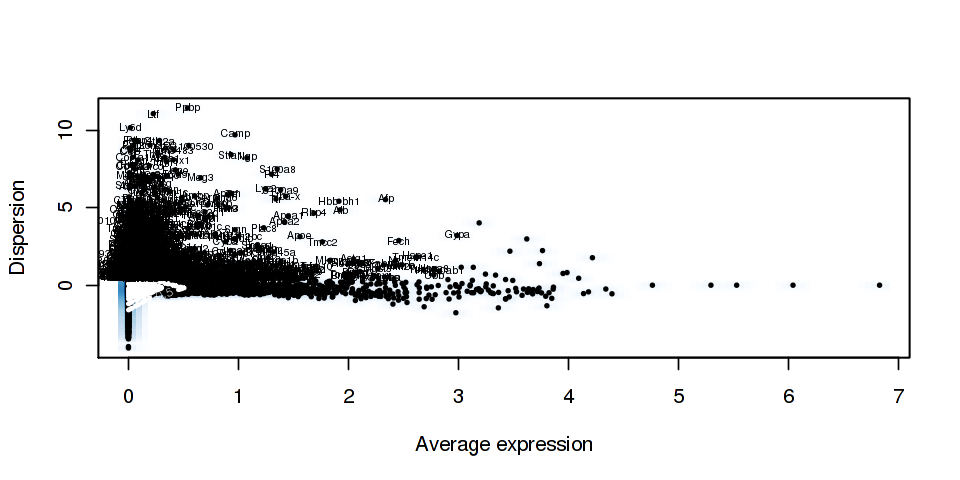

In [13]:
eryp <- FindVariableGenes(object = eryp, mean.function = ExpMean, dispersion.function = LogVMR, 
    x.low.cutoff = 0.0125, x.high.cutoff = 3, y.cutoff = 0.5)

In [16]:
length(x = eryp@var.genes)


[1] 1528

In [17]:
eryp <- ScaleData(object = eryp, vars.to.regress = c("nUMI", "percent.mito"))


Regressing out: nUMI, percent.mito



Time Elapsed:  1.4421669960022 mins

Scaling data matrix


In [18]:
eryp <- RunPCA(object = eryp, pc.genes = eryp@var.genes, do.print = TRUE, pcs.print = 1:5, 
    genes.print = 5)

[1] "PC1"
[1] "Cpox"  "Blvrb" "Fech"  "Hmbs"  "Gypa" 
[1] ""
[1] "Sepp1"  "Cyba"   "Apoe"   "Marcks" "Cd302" 
[1] ""
[1] ""
[1] "PC2"
[1] "Fgg"      "Fgb"      "Cyp2c68"  "Serpina6" "Aldob"   
[1] ""
[1] "Arhgdib"  "Rac2"     "Sh3bgrl3" "Arpc1b"   "Coro1a"  
[1] ""
[1] ""
[1] "PC3"
[1] "C1qc"  "C1qb"  "C1qa"  "Timd4" "Igf1" 
[1] ""
[1] "Cdk6"  "Srm"   "Ldha"  "Phgdh" "Tomm5"
[1] ""
[1] ""
[1] "PC4"
[1] "Sdpr"   "F2rl2"  "Rab27b" "Gp1bb"  "Pf4"   
[1] ""
[1] "Plac8"  "Hp"     "Prtn3"  "Emb"    "Tyrobp"
[1] ""
[1] ""
[1] "PC5"
[1] "Hspe1"  "Tomm5"  "Tomm20" "Srm"    "Ncl"   
[1] ""
[1] "Hp"       "Stfa1"    "Cebpe"    "Anxa1"    "Slc25a37"
[1] ""
[1] ""


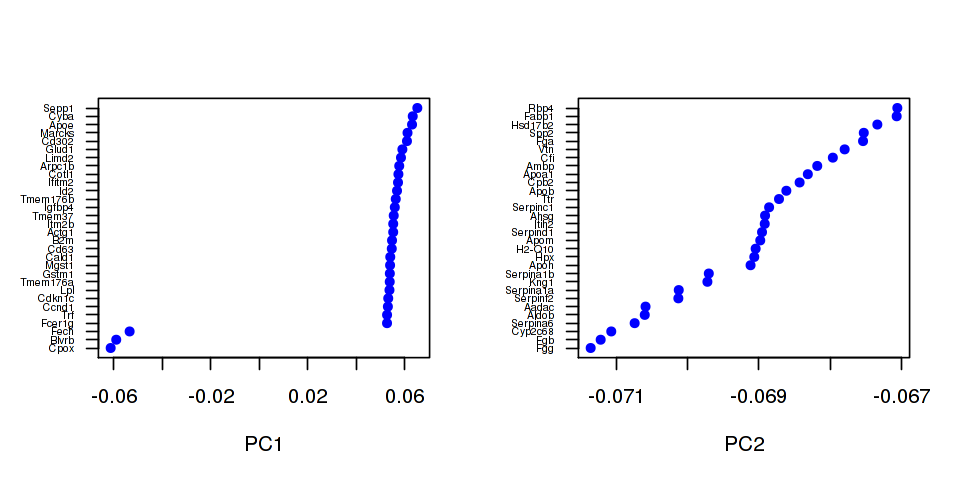

In [19]:
VizPCA(object = eryp, pcs.use = 1:2)


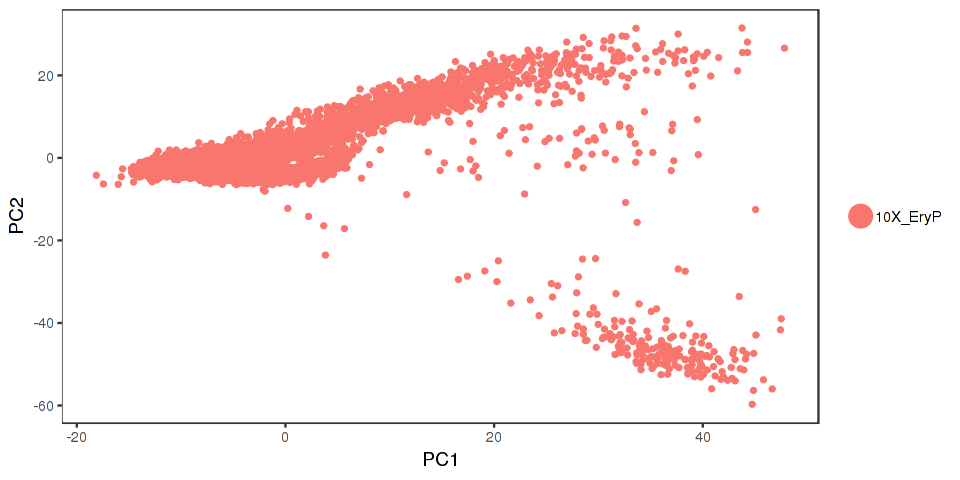

In [20]:
PCAPlot(object = eryp, dim.1 = 1, dim.2 = 2)


Warning message in heatmap.2(data.use, Rowv = NA, Colv = NA, trace = "none", col = col.use, :
“Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram.”Warning message in heatmap.2(data.use, Rowv = NA, Colv = NA, trace = "none", col = col.use, :
“Discrepancy: Colv is FALSE, while dendrogram is `column'. Omitting column dendogram.”Warning message in plot.window(...):
“"dimTitle" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"dimTitle" is not a graphical parameter”Warning message in title(...):
“"dimTitle" is not a graphical parameter”

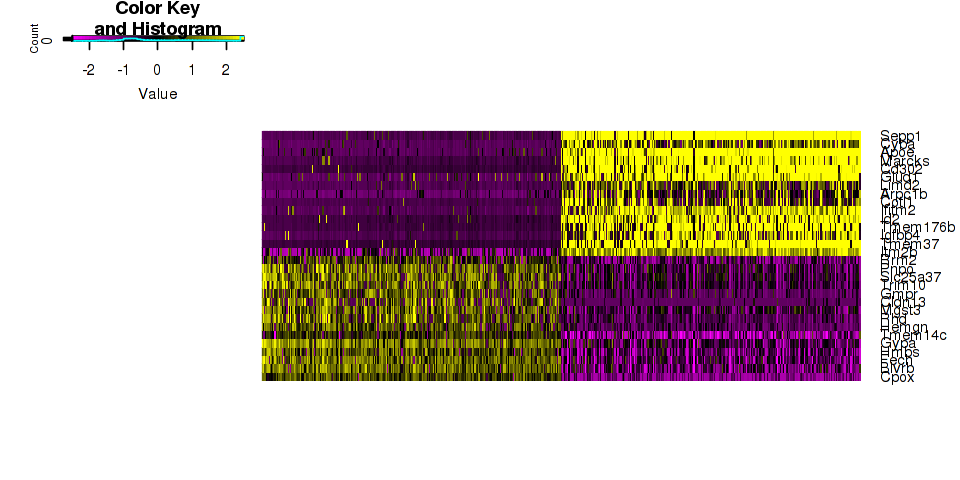

In [21]:
PCHeatmap(object = eryp, pc.use = 1, cells.use = 500, do.balanced = TRUE, label.columns = FALSE)


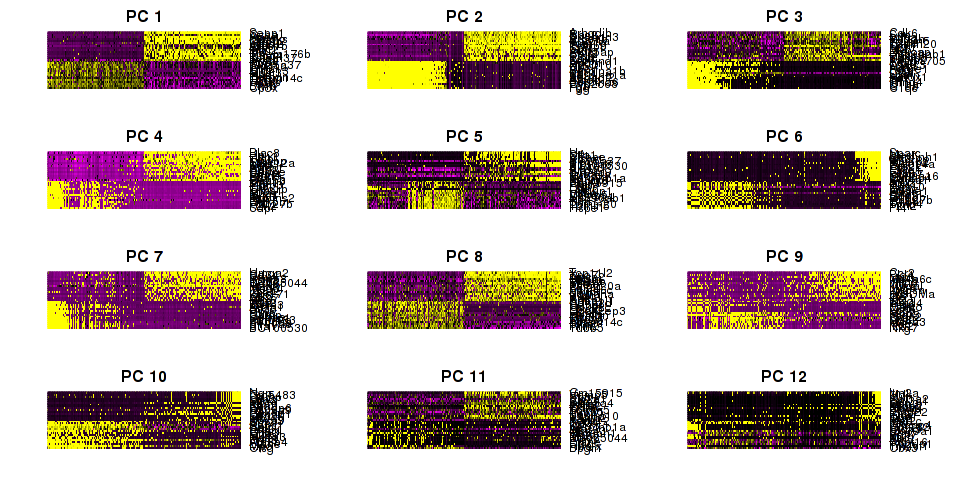

In [22]:
PCHeatmap(object = eryp, pc.use = 1:12, cells.use = 500, do.balanced = TRUE, 
    label.columns = FALSE, use.full = FALSE)

In [23]:
eryp <- JackStraw(object = eryp, num.replicate = 100, display.progress = TRUE)

  |======================================================================| 100%
Time Elapsed:  6.40494439999263 mins 



Warning message:
“Removed 21400 rows containing missing values (geom_point).”

An object of class seurat in project 10X_EryP 
 15590 genes across 7355 samples.

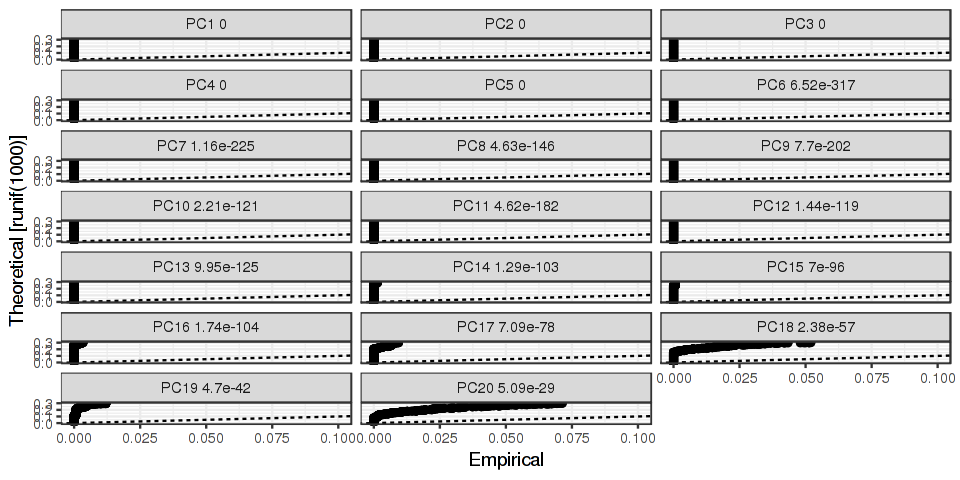

In [24]:
JackStrawPlot(object = eryp, PCs = 1:20)


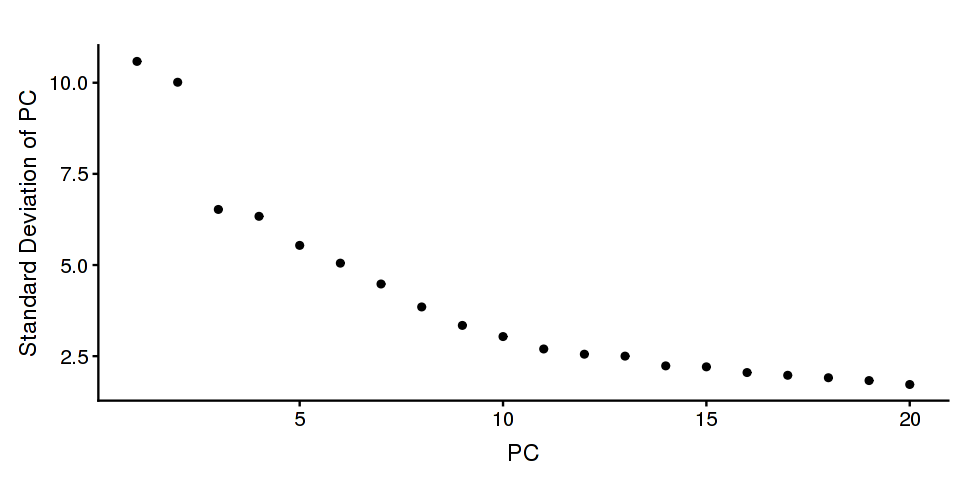

In [25]:
PCElbowPlot(object = eryp)

In [26]:
eryp <- FindClusters(object = eryp, reduction.type = "pca", dims.use = 1:17, 
    resolution = 0.6, print.output = 0, save.SNN = TRUE)

In [27]:
eryp <- RunTSNE(object = eryp, dims.use = 1:10, do.fast = TRUE)


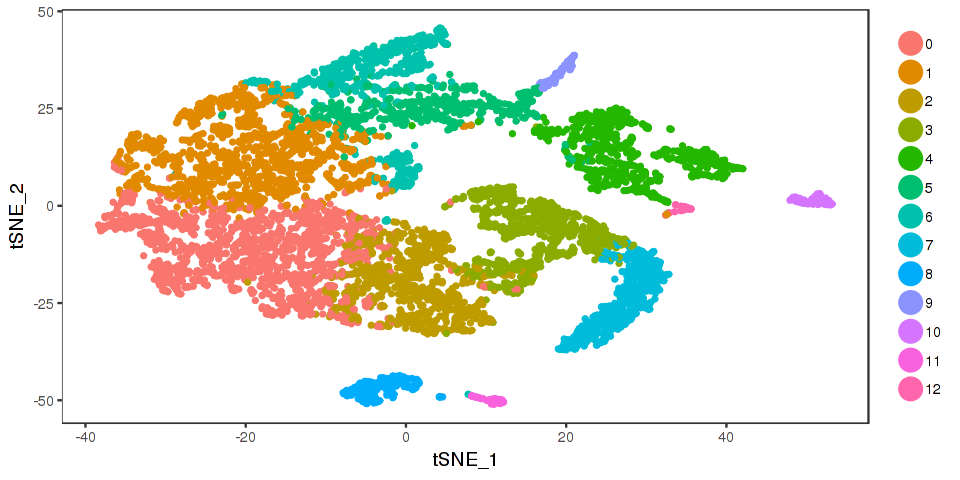

In [28]:
TSNEPlot(object = eryp)

In [29]:
eryp.adt <- read.csv("../../data/raw/cite-seq/protein/adt_counts.txt", 
    sep = ",", header = TRUE, row.names = 1)

In [30]:
head(eryp.adt)

,AGGCCACCACGTTGGC,AATCGGTAGCTAACTC,ATGGGAGGTCCTGCTT,TCACAAGGTCGCGGTT,GTGGGTCTCGAGCCCA,GCGCAGTTCCCTTGTG,TACGGATCACATGGGA,AGGGAGTTCGCGATCG,GTCATTTTCTTCGAGA,TCTGGAAGTACGCTGC,⋯,TTTGCGCTCGTTACAG,ACGAGGAGTTGCGTTA,CGCCAAGCAGGCTGAA,CAGAATCTCTGGTGTA,CTCGTACGTGAGGGAG,TCGTACCTCCGCGTTT,TATGCCCTCACCCTCA,GGCGACTTCTCCGGTT,CACAAACTCGGCTTGG,CGAATGTGTCTCGTTC
ADT1,2,4,1,7,10,47,7,26,7,3,⋯,6,247,14,5,5,3,6,3,7,26
ADT10,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ADT2,5,16,6,16,5,9,4,28,73,44,⋯,8,2,152,122,6,18,62,176,6,2
ADT3,5,7,9,6,15,42,19,37,8,4,⋯,9,22,5,3,8,3,11,7,9,3
ADT4,1,3,3,6,2,5,4,16,3,2,⋯,1,2,5,2,3,1,0,0,3,1
ADT5,7,13,20,15,4,13,9,67,15,9,⋯,11,5,11,15,10,14,12,8,14,6


In [31]:
dim(eryp.adt)

[1]   13 7863

In [32]:
# Add pseudocount
eryp.adt <- eryp.adt + replicate(7355, rnorm(11, 1, 0.1))

In [33]:
                        #ADT1    ADT10    ADT2
rownames(eryp.adt) <- c('CD11b', 'IgG', 'Ter119',
                        #ADT3    ADT4    ADT5
                        'CD41', 'Gr1', 'B220',
                        #ADT6    ADT7    ADT8
                        'cKit', 'CD3e', 'CD44',
                        #ADT9
                        'CD71', 'bad_struct', 'no_match', 'total_reads')

In [34]:
eryp.adt <- rbind(eryp.adt, colSums(eryp.adt[c('Gr1', 'CD11b', 'CD3e', 'CD41', 'B220'), ]))

In [35]:
rownames(eryp.adt)[14] <- 'Lin+'

In [36]:
rows_to_keep = !(rownames(eryp.adt) %in% c('bad_struct', 'no_match', 'total_reads'))

In [37]:
eryp.adt <- eryp.adt[rows_to_keep, ]

In [38]:
rownames(eryp.adt) <- paste0("CITE_", rownames(eryp.adt))

In [39]:
eryp.adt

,AGGCCACCACGTTGGC,AATCGGTAGCTAACTC,ATGGGAGGTCCTGCTT,TCACAAGGTCGCGGTT,GTGGGTCTCGAGCCCA,GCGCAGTTCCCTTGTG,TACGGATCACATGGGA,AGGGAGTTCGCGATCG,GTCATTTTCTTCGAGA,TCTGGAAGTACGCTGC,⋯,TTTGCGCTCGTTACAG,ACGAGGAGTTGCGTTA,CGCCAAGCAGGCTGAA,CAGAATCTCTGGTGTA,CTCGTACGTGAGGGAG,TCGTACCTCCGCGTTT,TATGCCCTCACCCTCA,GGCGACTTCTCCGGTT,CACAAACTCGGCTTGG,CGAATGTGTCTCGTTC
CITE_CD11b,2.9856020,5.1158352,2.015876,7.910945,10.9036107,47.963678,7.883744,26.980013,8.0351324,3.9578440,⋯,6.9923662,247.826931,14.9846837,6.0982607,6.119571,3.9438901,7.0161118,4.1099571,7.788839,26.9376723
CITE_IgG,0.9623691,0.9378711,1.035111,0.902178,0.9782288,1.142172,1.160471,1.071334,0.8527846,0.8999063,⋯,0.9832953,1.119254,0.9129226,0.8119801,1.080310,0.9912708,0.9037829,0.8387034,0.959175,0.7985394
CITE_Ter119,6.0842592,16.8734534,7.162340,16.915750,6.0426754,9.870003,5.061889,28.905080,73.9183364,45.0954953,⋯,9.0227422,3.046009,153.1583106,122.9506389,7.039977,19.0774272,62.9363404,176.9552616,7.074146,2.9026499
CITE_CD41,6.1437826,8.1050318,10.021546,6.826458,15.9480980,43.079910,19.951078,37.890520,9.0572507,5.0238283,⋯,9.9652083,22.771143,6.1240151,4.1016622,8.919632,4.0943522,11.9358242,7.9139074,9.925504,4.1021378
CITE_Gr1,1.9838313,4.0819266,4.011915,6.917922,2.9668989,6.007299,5.020978,17.044351,3.9441829,2.8933982,⋯,2.1132044,2.940986,5.9196125,2.9953621,3.919062,2.0090751,0.8480805,0.9680692,3.787624,2.0574450
CITE_B220,8.0072898,13.9577037,21.205619,15.957549,4.9795413,14.026351,10.034895,68.084352,15.8999715,9.9492411,⋯,11.9104726,5.970918,12.0711780,16.1020596,10.966227,14.9001699,12.8371836,8.9984351,14.869274,7.0417136
CITE_cKit,490.0718718,32.9023085,295.110092,88.992231,327.1436821,266.984054,351.854823,25.061922,12.2017187,25.8468936,⋯,658.9606634,178.945966,17.9587136,20.8976872,741.904123,53.9831291,12.0874867,5.9661211,878.917258,213.9464274
CITE_CD3e,2.1001539,5.0577246,3.866380,5.843778,6.1355957,12.934719,5.003853,65.871916,11.9639987,12.9450290,⋯,10.9388390,5.057555,5.0488379,13.0556665,8.754039,8.0289567,16.9874944,5.9434202,12.916053,6.9035550
CITE_CD44,195.0259056,196.0099660,195.009543,95.138037,183.0776366,295.009360,327.849427,14.996226,43.8968257,115.9730821,⋯,200.0245265,242.920953,47.9828622,55.0947990,299.036227,158.9260682,90.1543175,55.1309873,387.028871,117.0433538
CITE_CD71,225.8875368,1733.8997823,208.993265,391.898432,22.0837801,25.938624,12.998380,248.869583,751.8573624,1465.8399845,⋯,203.9275763,36.076270,99.9687609,809.1134641,173.939689,1068.0815905,1886.9518903,94.9633386,508.063482,12.9376927


In [40]:
eryp.adt <- eryp.adt[,(colnames(eryp.adt) %in% colnames(eryp@scale.data))]

In [41]:
eryp <- SetAssayData(eryp, assay.type = "CITE", slot = "raw.data", new.data = eryp.adt)


In [42]:
eryp <- NormalizeData(eryp, assay.type = "CITE", normalization.method = "genesCLR")

In [43]:
eryp <- ScaleData(eryp, assay.type = "CITE", display.progress = TRUE)

Scaling data matrix


In [44]:
eryp@assay$CITE@scale.data <- log10(as.matrix(eryp@assay$CITE@raw.data))

In [45]:
eryp@assay$CITE@data <- log10(as.matrix(eryp@assay$CITE@raw.data))

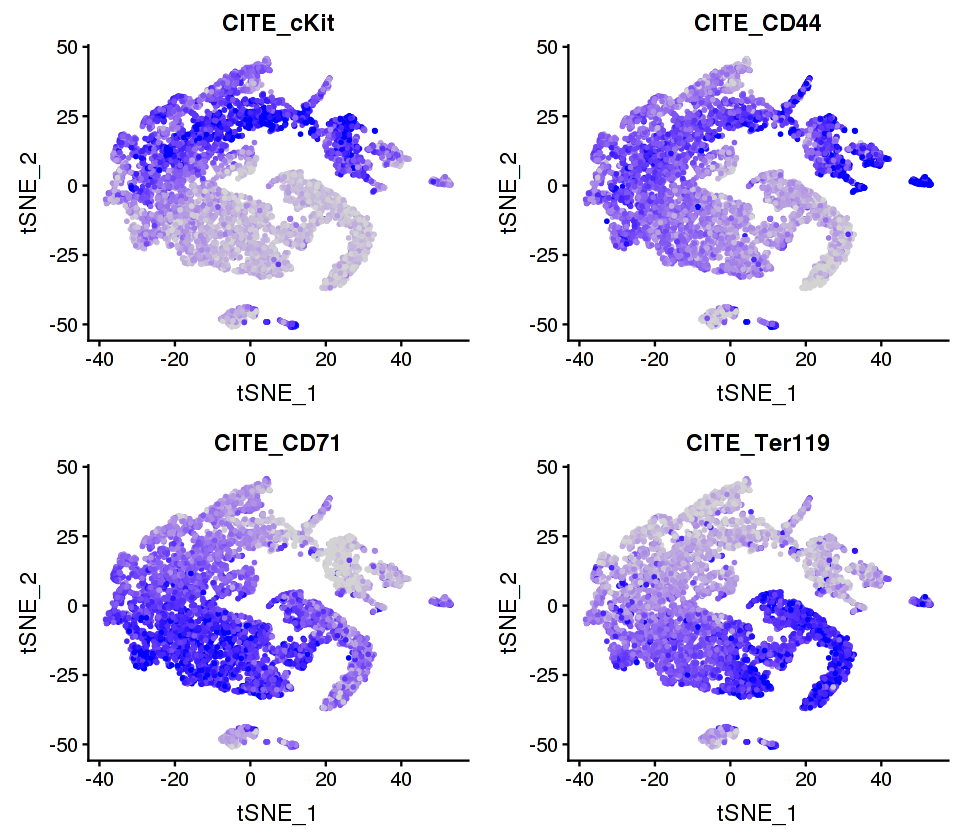

In [46]:
options(repr.plot.width=8, repr.plot.height=7)

FeaturePlot(eryp, features.plot = c("CITE_cKit", "CITE_CD44", "CITE_CD71", "CITE_Ter119"),
            min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "blue"))

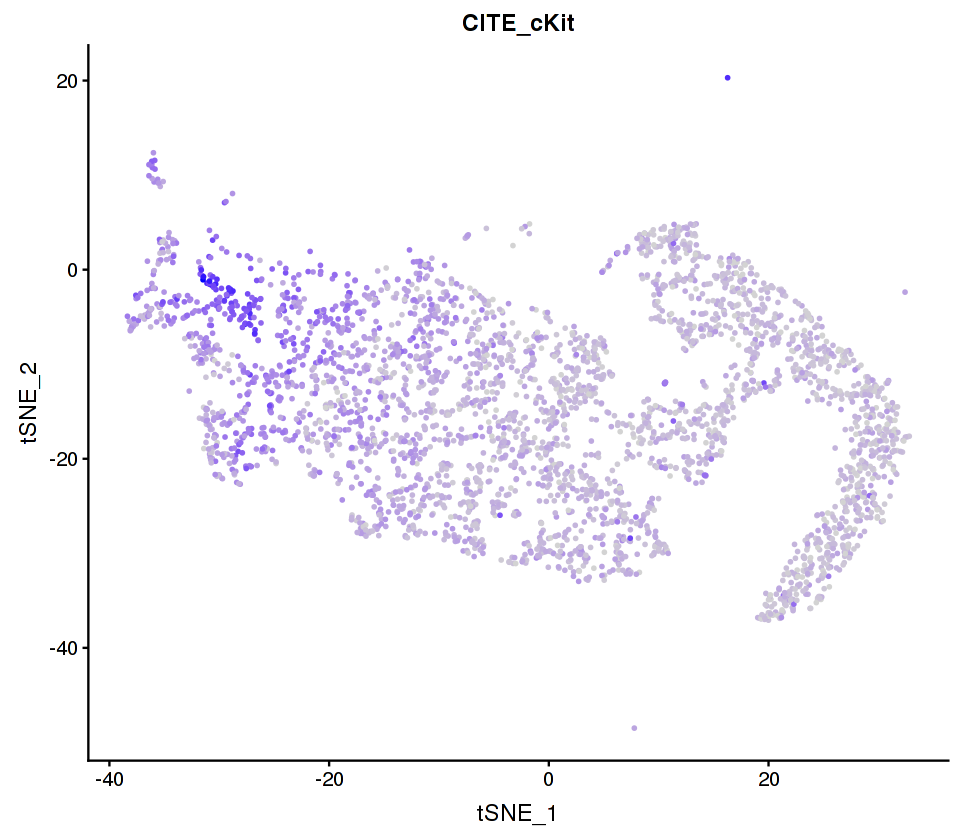

In [47]:
late <- SubsetData(eryp, ident.use=c(0,2,3,7))
FeaturePlot(late, features.plot = c("CITE_cKit"),
            min.cutoff = "q05", cols.use = c("lightgrey", "blue"))

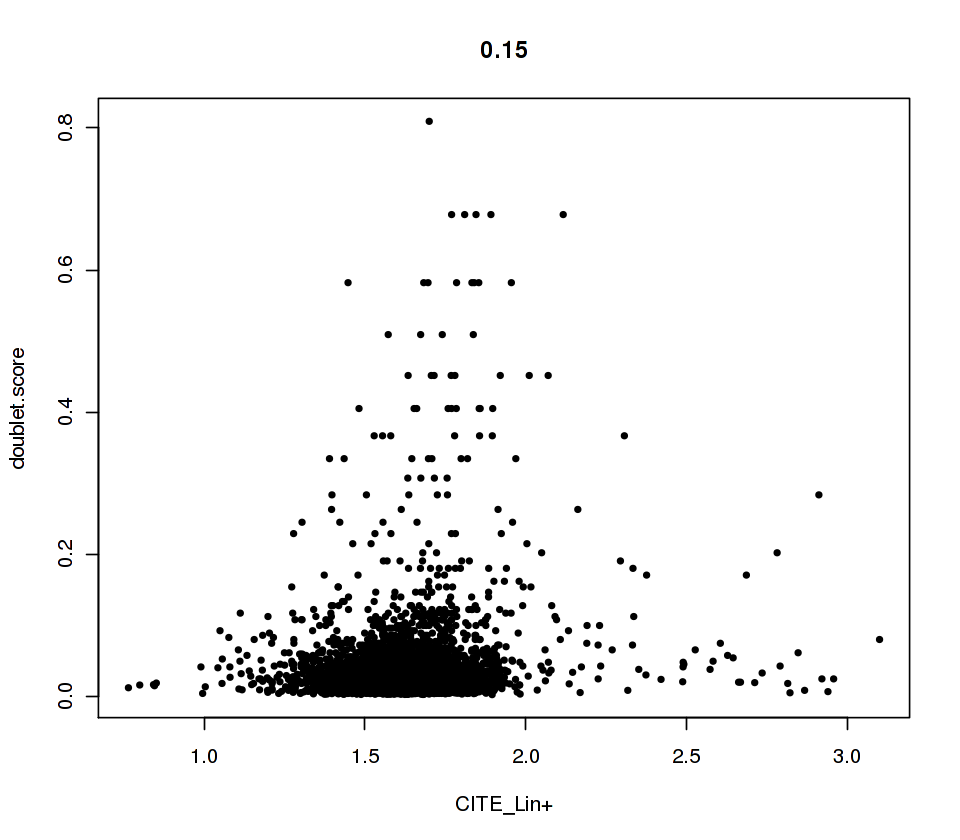

In [48]:
GenePlot(late, 'CITE_Lin+', 'doublet.score', col.use='black', cex=0.7)

In [49]:
save(eryp, file="../../data/intermediate/cite-seq/seurat-initial-qc.Robj")